In [147]:
import psycopg2


query = """Select details from outside_route_table;
"""


conn_str = "dbname='travel_with_friends' user='Gon' host='localhost'"

conn = psycopg2.connect(conn_str)
cur = conn.cursor()
cur.execute(query)
c = cur.fetchall()

In [173]:
c[2]

("[{'name': 'Marina Park', 'route': 1, 'coord_lat': 37.6958571, 'coord_long': -122.1866837, 'address': 'Monarch Bay Drive, San Leandro, California, 94577, United States', 'id': 6713L}, {'name': 'Coyote Hills Regional Park', 'route': 1, 'coord_lat': 37.5539961, 'coord_long': -122.0917822, 'address': '8000 Patterson Ranch Road, Fremont, California, 94555, United States', 'id': 2324L}, {'name': 'Ardenwood Historic Farm', 'route': 1, 'coord_lat': 37.5528547, 'coord_long': -122.0577824, 'address': '34600 Ardenwood Blvd, Fremont, California, 94555, United States', 'id': 2328L}, {'name': 'iFLY Indoor Skydiving San Francisco Bay', 'route': 1, 'coord_lat': 37.5986031, 'coord_long': -122.0656355, 'address': '31310 Alvarado Niles Rd, Union City, California, 94587, United States', 'id': 8221L}, {'name': 'Union Landing Shopping Center', 'route': 1, 'coord_lat': 37.599771, 'coord_long': -122.0656455, 'address': 'Union Landing Blvd., Union City, California, 94587, United States', 'id': 8222L}, {'name

In [168]:
import ast
item= 2
all_lat, all_long =[],[]
for i in range(len(ast.literal_eval(c[item][0]))):
    all_lat.append(ast.literal_eval(c[item][0])[i]["coord_lat"])
    all_long.append(ast.literal_eval(c[item][0])[i]["coord_long"])

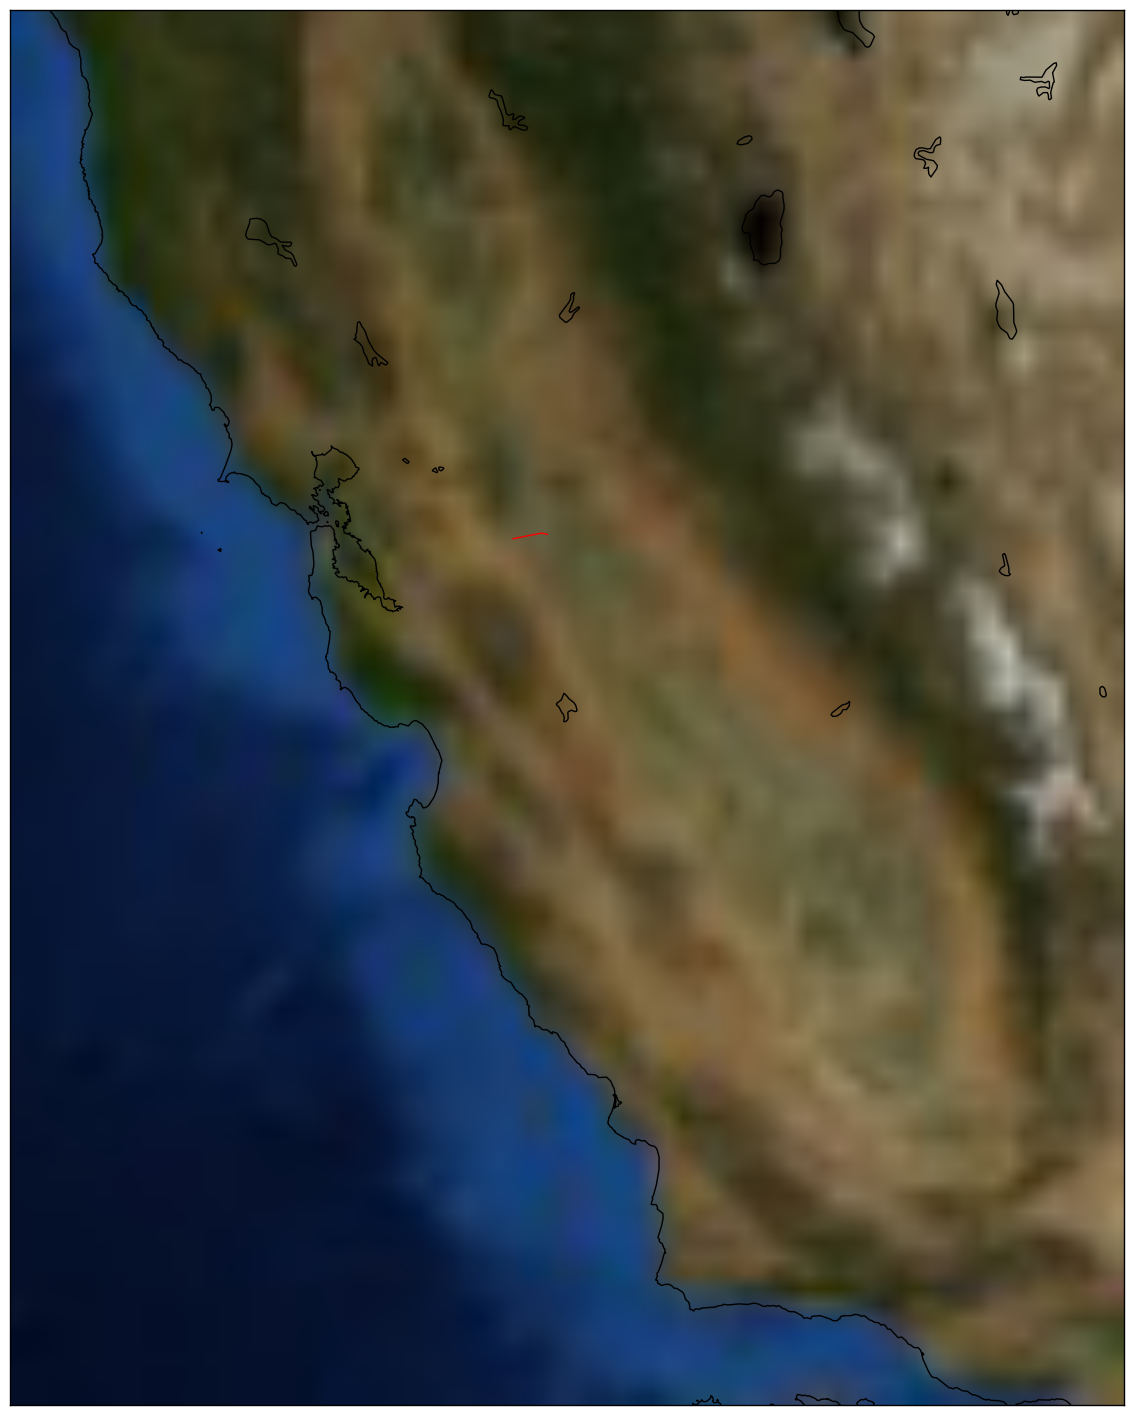

In [183]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure(figsize=(18,18)) 

map = Basemap(projection='lcc', lat_0 = 37, lon_0 = -121,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-124, llcrnrlat=34,
    urcrnrlon=-118, urcrnrlat=40)
 
map.drawcoastlines()
map.drawcountries()
# map.fillcontinents(color = 'coral')
map.drawmapboundary()
map.bluemarble()

lons = all_long
lats = all_lat
x,y = map(lons, lats)
map.plot(x, y, 'red', markersize=10)
 

plt.show()


In [2]:
# query = """SELECT name, city, state
# FROM poi_detail_table_v2
# WHERE ST_Distance_Sphere(geom, ST_MakePoint(-122.6659597,45.5083437)) <= 100 * 1609.34;"""

In [8]:
# def travel_outside_coords(current_city, current_state, direction=None, n_days=1):
#     conn = psycopg2.connect(conn_str)   
#     cur = conn.cursor() 
#     #coord_long, coord_lat
#     cur.execute("select index, coord_lat, coord_long from all_cities_coords_table where city ='%s' and state = '%s';" %(current_city, current_state)) 
#     id_, coord_lat, coord_long = cur.fetchone()
#     #city, coord_lat, coord_long
#     cur.execute("select distinct city, coord_lat, coord_long from all_cities_coords_table where city !='%s' and state = '%s';" %(current_city, current_state))  
#     coords = cur.fetchall()    
    
#     conn.close()
    
#     return id_, coords, coord_lat, coord_long

In [102]:
# def direction_from_orgin(start_coord_long,  start_coord_lat, target_coord_long, target_coord_lat):
#     angle = calculate_initial_compass_bearing((start_coord_lat, start_coord_long), (target_coord_lat, target_coord_long))
#     if (angle > 45) and (angle < 135):
#         return 'E'
#     elif (angle > 135) and (angle < 215):
#         return 'S'
#     elif (angle > 215) and (angle < 305):
#         return 'W'
#     else:
#         return 'N'
# def check_direction(start_lat, start_long, outside_lat, outside_long, target_direction):
#     angle_dict={"E":range(45,135), "S":range(135,215), "W":range(215,305), "N":range(0,45) + range(305,360)}
#     angle = calculate_initial_compass_bearing((start_lat, start_long), (outside_lat, outside_long))

#     if int(angle) in angle_dict[target_direction]:
#         return True
#     else: 
#         return False

In [99]:
# target_direction = "N"
# angle_dict={"E":range(45,135), "S":range(135,215), "W":range(215,305), "N":range(0,45) + range(305,360)}

# angle = 41.0645080748
# # print angle_dict[target_direction]
# if int(angle) in angle_dict[target_direction]:
#     print angle

41.0645080748


In [130]:
from outside_helpers import *
coord_lat, coord_long = 37.7792808, -122.4192362
origin_city,origin_state = "San Francisco", "California"
city_id, coord_lat, coord_long, city_infos =travel_outside_with_direction(origin_city,origin_state,"S",140)
poi_coords = city_infos[:,1:3]
n_routes = sum(1 for t in np.array(city_infos)[:,3] if t >= 120)/10
if (n_routes>1) and (city_infos.shape[0]>=10):
    kmeans = KMeans(n_clusters=n_routes).fit(poi_coords)
elif (city_infos.shape[0]> 20) or (n_routes>1):
    kmeans = KMeans(n_clusters=2).fit(poi_coords)
else:
    kmeans = KMeans(n_clusters=1).fit(poi_coords)
route_labels = kmeans.labels_
# print n_routes, len(route_labels), city_infos.shape
# print route_labels
outside_route_ids, outside_trip_details,event_id_lst =[],[],[]
for i in range(n_routes):
    current_events, big_ix, med_ix, small_ix = [], [],[], []
    for ix, label in enumerate(route_labels):
        if label == i:
            time = city_infos[ix,3]
            event_ix = city_infos[ix,0]
            current_events.append(event_ix)
            if time > 180 :
                big_ix.append(ix)
            elif time >= 120 :
                med_ix.append(ix)
            else:
                small_ix.append(ix)
    big_ = sorted_events(city_infos, big_ix)
    med_ = sorted_events(city_infos, med_ix)
    small_ = sorted_events(city_infos, small_ix)
    # need to update!!!!!!!!
    event_ids, event_type = create_event_id_list(big_, med_, small_)
    event_ids, event_type = db_outside_event_cloest_distance(coord_lat, coord_long, event_ids = event_ids, event_type = event_type)
    event_ids, google_ids, name_list, driving_time_list, walking_time_list =db_outside_google_driving_walking_time(city_id, coord_lat,coord_long, event_ids, event_type, origin_city = origin_city, origin_state = origin_state)
    #why bug????
    event_ids, driving_time_list, walking_time_list, total_time_spent = db_remove_outside_extra_events(event_ids, driving_time_list, walking_time_list)
    outside_route_id = outside_trip_id + '-'+str(i)
#             values = db_outside_route_trip_details(outside_route_id, event_ids, origin_city, origin_state, regular, full_day,n_days,i)

    details = db_outside_route_trip_details(event_ids,i)

ProgrammingError: relation "google_city_to_poi_table" does not exist
LINE 1: select index from google_city_to_poi_table                  ...
                          ^


In [128]:
def travel_outside_with_direction (current_city, current_state, target_direction, furthest_len, n_days=1):
    poi_info = []
    conn = psycopg2.connect(conn_str)   
    cur = conn.cursor() 
    #coord_long, coord_lat
    cur.execute("select index, coord_lat, coord_long from all_cities_coords_table where city ='%s' and state = '%s';" %(current_city, current_state)) 
    id_, start_lat, start_long = cur.fetchone()
    cur.execute("SELECT index, coord_lat, coord_long, adjusted_visit_length, ranking, review_score, num_reviews FROM poi_detail_table_v2 WHERE city != '%s' and ST_Distance_Sphere(geom, ST_MakePoint(%s,%s)) <= %s * 1609.34;"%(current_city, start_long, start_lat,furthest_len)) 
    item = cur.fetchall()
    conn.close()
    for coords in item:
        if check_direction(start_lat, start_long, coords[1] ,coords[2], target_direction):
            poi_info.append(coords)
    return id_, start_lat, start_long, np.array(poi_info)
    
    


In [30]:
# import city_trip as trip
# # state = 'Virginia'
# # city = 'Newport News'
# state, city = ('Washington', 'Auburn')



# n_days = [1,2,3,4,5]
# for day in n_days:
#     trip.get_fulltrip_data(state, city, int(day))
        

In [3]:
# import city_trip as trip

# for x in range(len(c)):
#     state, city = c[x]
#     if (state == 'Puerto Rico') or (state == 'Virgin Islands'):
#         continue
#     print c[x]
#     n_days = [1,2,3,4,5]
#     for day in n_days:
#         trip.get_fulltrip_data(state, city, int(day))
# not_visited_poi_lst =[]        
# bool(not_visited_poi_lst)

In [4]:
# import psycopg2

# conn_str = "dbname='travel_with_friends' user='Gon' host='localhost'"

# conn = psycopg2.connect(conn_str)
# cur = conn.cursor()
# cur.execute("select max(index) from full_trip_table;")
# full_trip_index = cur.fetchone()[0]
# print full_trip_index
# cur.execute("select county, state from full_trip_table where index='%s';"%(432)) 
# location = cur.fetchone()       
# print location
# cur.execute("select index, county, state, city from county_table where county ='%s' and state='%s';"%(location[0],location[1]))
# index = cur.fetchall()[-1]
# print index
# print index[0]
# conn.close()

In [5]:
# from pyschedule import Scenario, solvers, plotters
# S = Scenario('hello_pyschedule',horizon=30)

# # Create two resources
# Day1, Day2 = S.Resource('Day1'), S.Resource('Day2')

# # Create three tasks with lengths 1,2 and 3
# id1,id2,id3 = S.Task('id1',6), S.Task('id2',12), S.Task('id3',18)

# # Assign tasks to resources, either Alice or Bob
# id1 += Day1
# id2 += Day1|Day2
# id3 += Day1|Day2

# # Solve and print solution
# S.use_makespan_objective()
# solvers.mip.solve(S,msg=1)

# # Print the solution
# print(S.solution())



In [6]:
# import psycopg2
# import city_trip as trip


# conn_str = "dbname='travel_with_friends' user='Gon' host='localhost'"
# state, city = ('Florida', 'Venus')

# conn = psycopg2.connect(conn_str)
# cur = conn.cursor()
# cur.execute("select state, city from county_table where index >24450;")
# # cur.execute("select * from county_table where state = '%s' and city = '%s';"%(state,city))
# c = cur.fetchall()
# print c

In [169]:
print all_lat, all_long

[37.7628538, 37.787642, 37.7822705] [-121.4133086, -121.2577032, -121.2261125]
